In [1]:
import sys
# import sibling folder
sys.path.append("..")

In [2]:
import os
import numpy as np
import pandas as pd
from llama_cpp import Llama

import experiments.utils as utils
from pprint import pprint
from IPython.display import display_markdown

In [3]:
plots_base_path = '../docs/plots/experiments/cot'

In [4]:
# init datasets
valid_ds_mini, valid_ds_small, incontext_ds_small, valid_ds_big, incontext_ds_big = utils.load_ds()
test_ds = utils.load_test()

# model names
small_model_repo_id="bartowski/Qwen2.5-0.5B-Instruct-GGUF"
small_model_file_name="Qwen2.5-0.5B-Instruct-IQ2_M.gguf"

big_model_repo_id="bartowski/Qwen2.5-1.5B-Instruct-GGUF"
big_model_file_name="Qwen2.5-1.5B-Instruct-IQ2_M.gguf"

llama_init_from_model: n_ctx_per_seq (4096) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_b

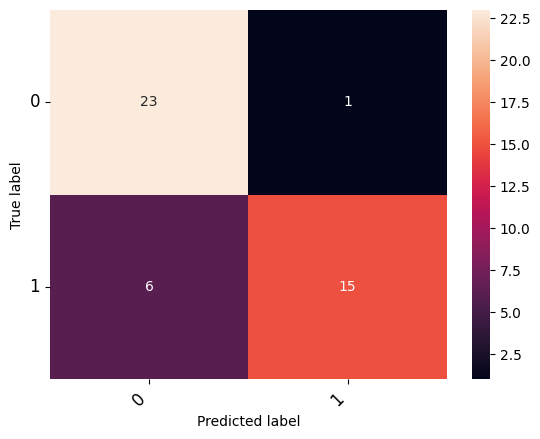

In [5]:
from experiments.cot_experiment import CotExperiment
cot_exp = CotExperiment(repo_id=small_model_repo_id, file_name=small_model_file_name, n_ctx=1024*4, valid_ds=valid_ds_mini)
cot_exp.max_tokens = -1
cot_exp_eval = cot_exp().eval()
fig=utils.plot_cm(cot_exp_eval['confusion_matrix'])
fig.savefig(f'{plots_base_path}/cm_cot_default.png')

In [6]:
pprint(cot_exp_eval)

{'accuracy': 0.8444444444444444,
 'confusion_matrix': array([[23,  1],
       [ 6, 15]]),
 'f1_score': 0.8108108108108109,
 'precision': 0.9375,
 'recall': 0.7142857142857143,
 'valid_answer_ratio': np.float64(0.703125)}


In [7]:
# peek for generations
print(cot_exp.preds)

[0, 0, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, 0, 0, -1, 1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, -1, 1, 1, 1, 0, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, 0, 0, 1, -1, -1, 0, 1, 1, 1, -1, 1]


In [8]:
cot_exp.get_run_log()[4]

{'system_promt': 'You are a helpful large language model that understands sentiment of a movie review inside <review>...</review> tags. \nRespond in the following format, using careful step-by-step reasoning.\n<reasoning>\n...\n</reasoning>\n<answer>\n...\n</answer>\nYour answer must be either Negative or Positive',
 'user_prompt': "<review>i already gave my comment on this movie under the name brucev3. now under brucev13 i want to add something! now after a long time i have seen a lot of so called heroic bloodshed titles! but not many come close to the action shown in john woo movies! that's why after all these years i think it is strange that 'china white' doesn't get the credit it deserves! no matter what version you have seen! the action is top notch! the scenery,china town in amsterdam is very unique. you get the impression it is a large district. but having lived in amsterdam myself i know it is only a small area part of the red light district which happen to have a lot of chines

0.2


running validation set: 100%|██████████| 64/64 [09:14<00:00,  8.67s/it]


0.4


running validation set: 100%|██████████| 64/64 [05:41<00:00,  5.33s/it]


0.6000000000000001


running validation set: 100%|██████████| 64/64 [05:33<00:00,  5.21s/it]


0.8


running validation set: 100%|██████████| 64/64 [02:06<00:00,  1.98s/it]


1.0


running validation set: 100%|██████████| 64/64 [02:52<00:00,  2.69s/it]


1.2000000000000002


running validation set: 100%|██████████| 64/64 [01:15<00:00,  1.18s/it]


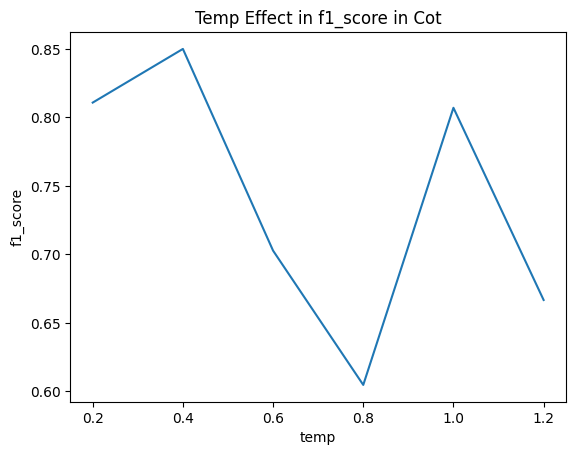

In [9]:

metric_cot_temp = utils.temp_check_helper(cot_exp)
fig_temp_f1 = utils.plot_metrics(metric_cot_temp,x_key='temp',y_key='f1_score',title='Temp Effect in f1_score in Cot')
fig_temp_f1.savefig(f'{plots_base_path}/temp_f1.png')

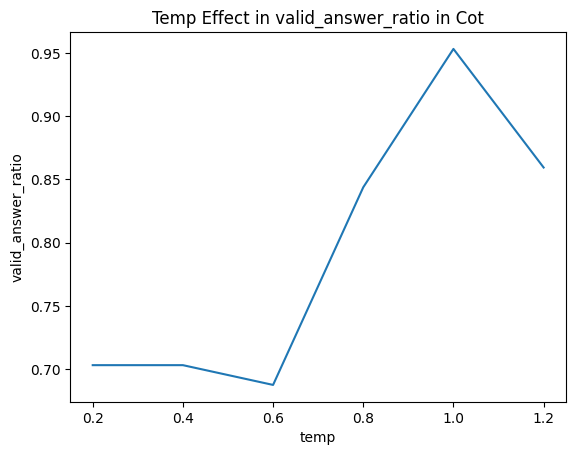

In [10]:
fig_temp_var = utils.plot_metrics(metric_cot_temp,x_key='temp',y_key='valid_answer_ratio',title='Temp Effect in valid_answer_ratio in Cot')
fig_temp_var.savefig(f'{plots_base_path}/temp_var.png')

In [ ]:
# cot_exp.stop = ['positive','negative','Positive','Negative']

In [25]:
# repetition penalty
cot_exp = CotExperiment(repo_id=small_model_repo_id, file_name=small_model_file_name, n_ctx=1024*4, valid_ds=valid_ds_mini)
cot_exp.temperature = 0.4
cot_exp.max_tokens = -1
metrics = []
cot_exp.temperature = 0.4
for r in [1.0, 1.2, 1.5, 2.0,3.0]:
    cot_exp.repeat_penalty = r
    cot_eval = cot_exp().eval()
    metrics.append({'repeat':r,'f1_score':cot_eval['f1_score'],'valid_answer_ratio':cot_eval['valid_answer_ratio']})
    print(cot_eval)

llama_init_from_model: n_ctx_per_seq (4096) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_b

{'accuracy': 0.8666666666666667, 'recall': 0.8095238095238095, 'precision': 0.8947368421052632, 'f1_score': 0.85, 'confusion_matrix': array([[22,  2],
       [ 4, 17]]), 'valid_answer_ratio': np.float64(0.703125)}


running validation set: 100%|██████████| 64/64 [01:13<00:00,  1.14s/it]


{'accuracy': 0.6458333333333334, 'recall': 0.375, 'precision': 0.8181818181818182, 'f1_score': 0.5142857142857142, 'confusion_matrix': array([[22,  2],
       [15,  9]]), 'valid_answer_ratio': np.float64(0.75)}


running validation set: 100%|██████████| 64/64 [03:45<00:00,  3.52s/it]


{'accuracy': 0.7142857142857143, 'recall': 0.4642857142857143, 'precision': 0.9285714285714286, 'f1_score': 0.6190476190476191, 'confusion_matrix': array([[27,  1],
       [15, 13]]), 'valid_answer_ratio': np.float64(0.875)}


running validation set: 100%|██████████| 64/64 [04:49<00:00,  4.52s/it]


{'accuracy': 0.6415094339622641, 'recall': 0.4230769230769231, 'precision': 0.7333333333333333, 'f1_score': 0.5365853658536586, 'confusion_matrix': array([[23,  4],
       [15, 11]]), 'valid_answer_ratio': np.float64(0.828125)}


running validation set: 100%|██████████| 64/64 [04:47<00:00,  4.50s/it]


{'accuracy': 0.6226415094339622, 'recall': 0.4230769230769231, 'precision': 0.6875, 'f1_score': 0.5238095238095238, 'confusion_matrix': array([[22,  5],
       [15, 11]]), 'valid_answer_ratio': np.float64(0.828125)}


running validation set: 100%|██████████| 64/64 [04:46<00:00,  4.47s/it]

{'accuracy': 0.6226415094339622, 'recall': 0.4230769230769231, 'precision': 0.6875, 'f1_score': 0.5238095238095238, 'confusion_matrix': array([[22,  5],
       [15, 11]]), 'valid_answer_ratio': np.float64(0.828125)}


In [27]:
cot_exp.repeat_penalty = 1.1
cot_eval = cot_exp().eval()
metrics.append({'repeat':r,'f1_score':cot_eval['f1_score'],'valid_answer_ratio':cot_eval['valid_answer_ratio']})

running validation set: 100%|██████████| 64/64 [01:06<00:00,  1.04s/it]


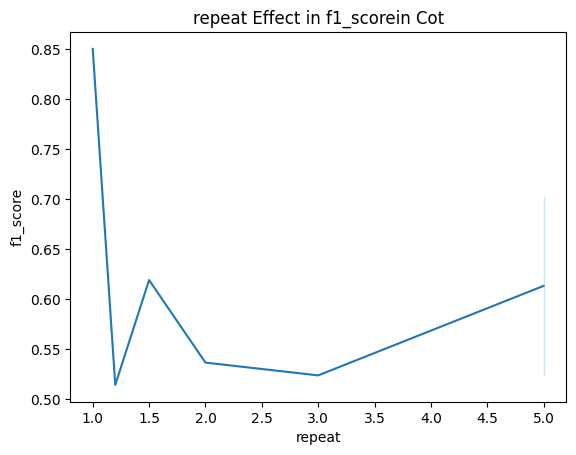

In [28]:
# based on best r check 
fig_repeat_f1 = utils.plot_metrics(metrics,x_key='repeat',y_key='f1_score',title='repeat Effect in f1_scorein Cot')
fig_repeat_f1.savefig(f'{plots_base_path}/repeat_f1.png')


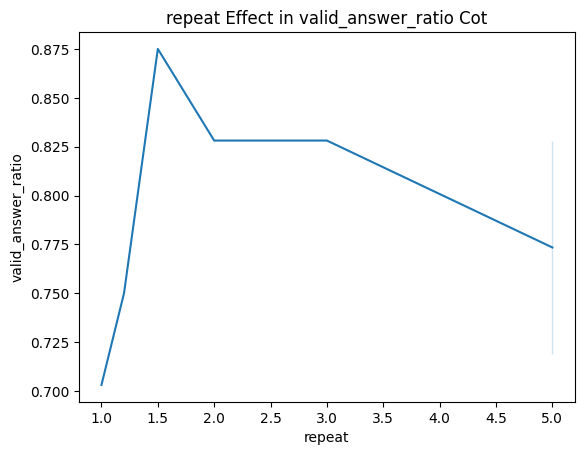

In [32]:
fig_repeat_var = utils.plot_metrics(metrics,x_key='repeat',y_key='valid_answer_ratio',title='repeat Effect in valid_answer_ratio Cot')
fig_repeat_var.savefig(f'{plots_base_path}/repeat_var.png')


In [46]:
cot_exp.preds

[0,
 -1,
 -1,
 0,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 0,
 0,
 -1,
 -1,
 -1,
 0,
 0,
 -1,
 0,
 0,
 -1,
 1,
 0,
 -1,
 0,
 -1,
 -1,
 -1,
 0,
 -1,
 0,
 -1,
 -1,
 0,
 -1,
 0,
 -1,
 -1,
 0,
 -1,
 -1,
 0,
 -1,
 0,
 -1,
 0,
 0,
 -1,
 -1,
 0,
 -1,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 -1,
 0,
 0,
 1,
 0,
 0,
 -1,
 1,
 -1,
 -1,
 0,
 1,
 0,
 -1,
 -1,
 0,
 -1,
 -1,
 0,
 1,
 0,
 0,
 -1,
 0,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 0,
 -1,
 1,
 0,
 -1,
 0,
 0,
 0,
 -1,
 1,
 1,
 -1,
 0,
 -1,
 1,
 0,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 0,
 1,
 1,
 -1,
 0,
 -1,
 0,
 1,
 0,
 -1,
 -1,
 -1,
 0,
 0,
 0,
 -1,
 -1,
 0,
 -1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 -1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 -1,
 -1,
 -1,
 1,
 0,
 -1,
 0,
 -1,
 0,
 0,
 -1,
 -1,
 0,
 0,
 0,
 -1,
 0,
 -1,
 -1,
 0,
 -1,
 0,
 -1,
 -1,
 0,
 -1,
 -1,
 0,
 1,
 -1,
 0,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 0,
 1,
 -1,
 1,
 0,
 0,
 1,
 -1,
 -1,
 0,
 0,
 1,
 -1,
 1,
 -1,
 0,
 0,
 0,
 -1,
 -1,
 0,
 -1,
 -1,
 1,
 -1,
 

In [48]:
cot_exp = CotExperiment(repo_id=small_model_repo_id, file_name=small_model_file_name, n_ctx=1024*4, valid_ds=test_ds)
# set variables
cot_exp.max_tokens = -1
cot_exp.temperature = 1.0
cot_exp_eval = cot_exp().eval()

llama_init_from_model: n_ctx_per_seq (4096) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_b

In [51]:
cot_exp_eval

{'accuracy': 0.8423645320197044,
 'recall': 0.7160493827160493,
 'precision': 0.8656716417910447,
 'f1_score': 0.7837837837837838,
 'confusion_matrix': array([[113,   9],
        [ 23,  58]]),
 'valid_answer_ratio': np.float64(0.79296875)}

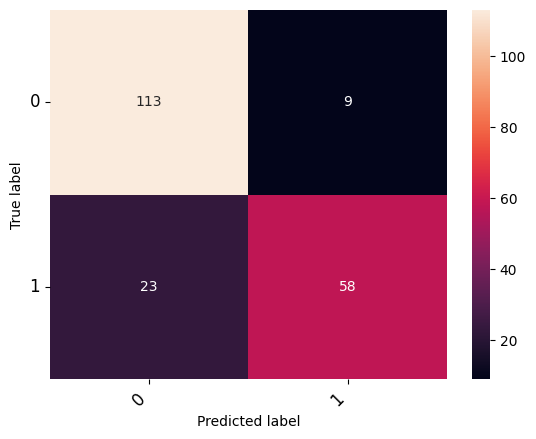

In [50]:
fig_test=utils.plot_cm(cot_exp_eval['confusion_matrix'])
fig_test.savefig(f'{plots_base_path}/cm_cot_test.png')